# EEG Data - Group Analysis

Analyze aperiodic activity across the group (MIPDB Dataset).

In [1]:
%matplotlib inline

import os
import csv

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, ttest_rel
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar, rcParams

import mne

In [2]:
# Import custom project related code
import sys
sys.path.append('../code')

# Import custom project related code
from db import EEGDB
from utils import load_pickle
from plts import plot_scatter
from analysis import comb_corrs, bet_corrs

## Settings

In [3]:
#corr_func = spearmanr
corr_func = pearsonr

In [360]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_context('talk')

In [4]:
SAVE_FIG = True

In [359]:
def cohens_d(d1, d2):
    return (np.mean(d1) - np.mean(d2)) / (np.sqrt((np.std(d1) ** 2 + np.std(d2) ** 2) / 2))

## Setup

In [5]:
# Get project database object
db = EEGDB()

In [6]:
# Load data readme file
rmd_file = os.path.join(db.data_path, 'EEG', 'MIPDB_PublicFile.csv')
rmd_df = pd.read_csv(rmd_file, index_col='ID')

### Load subject data

In [7]:
# Check for saved FOOOF files
fres_files = db.check_fooof()

In [8]:
# Load all data into a list
all_data = [load_pickle(f_name, db.fooof_path) for f_name in fres_files]

# Check number of subjects
n_subjs = len(all_data)
print(n_subjs, ' subjects.')

97  subjects.


In [9]:
# Initialize dataframe to store aperiodic data
ap_df = pd.DataFrame(columns=['ID', 'age',
                              'mean_exp_EO', 'median_exp_EO',
                              'mean_exp_EC', 'median_exp_EC'])

# Collect data from all subjects
for data in all_data:
    
    ap_data = {'ID': data['ID'],
               'age': rmd_df.loc[data['ID']]['Age'],
               'mean_exp_EO': np.mean(data['sls_eo_avg']),
               'median_exp_EO': np.median(data['sls_eo_avg']),
               'mean_exp_EC': np.mean(data['sls_ec_avg']),
               'median_exp_EC': np.median(data['sls_ec_avg'])}
    
    ap_df = ap_df.append(ap_data, ignore_index=True)

In [10]:
# Check out the dataframe
ap_df.head()

,ID,age,mean_exp_EO,median_exp_EO,mean_exp_EC,median_exp_EC
0,A00062704,32.0,1.501144,1.515592,1.407570,1.398595
1,A00054930,18.0,1.652110,1.669927,1.887614,1.899271
2,A00062919,22.0,1.031232,1.024979,1.290424,1.311356
3,A00062578,32.0,0.862034,0.819549,0.490674,0.455303
4,A00053440,12.0,2.010997,2.047516,1.879631,1.927993


In [11]:
# Descriptive statistics
ap_df.describe()

,age,mean_exp_EO,median_exp_EO,mean_exp_EC,median_exp_EC
count,97.000000,97.000000,97.000000,97.000000,97.000000
mean,15.536082,1.620618,1.628748,1.670201,1.673671
std,7.860850,0.337902,0.333439,0.334073,0.337170
min,6.000000,0.862034,0.819549,0.490674,0.455303
25%,10.000000,1.381715,1.381238,1.428849,1.435579
50%,13.000000,1.660264,1.671098,1.690207,1.690879
75%,18.000000,1.899647,1.893650,1.904737,1.916576
max,44.000000,2.268051,2.260224,2.383702,2.408580


In [12]:
# Save out AP dataframe
ap_df.to_csv('childmind_ap.csv')

In [362]:
# Compare between EO & EC
ttest_rel(ap_df['median_exp_EC'].values, ap_df['median_exp_EO'].values)

Ttest_relResult(statistic=2.1582320320354063, pvalue=0.03340395583179032)

In [365]:
cohens_d(ap_df['mean_exp_EC'].values, ap_df['mean_exp_EO'].values)

0.14833924050826078

### TITLE

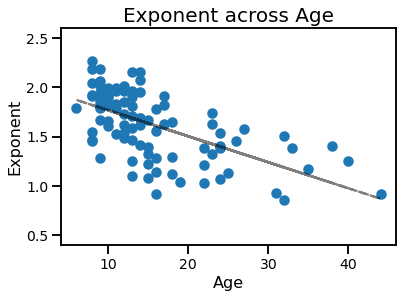

In [176]:
# Plot exponent data relation to age - EO
plot_scatter(ap_df['age'], ap_df['mean_exp_EO'], ylim=[0.4, 2.6],
             title='Exponent across Age', xlabel='Age', ylabel='Exponent', 
             save_fig=SAVE_FIG, file_name='exp-age-corr-eo')

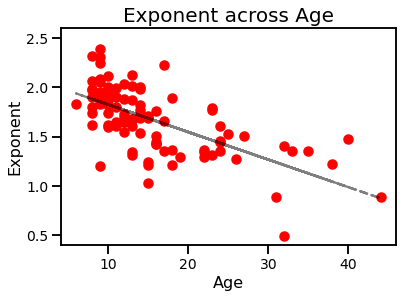

In [177]:
# Plot exponent data relation to age - EO
plot_scatter(ap_df['age'], ap_df['mean_exp_EC'], ylim=[0.4, 2.6], color='red',
             title='Exponent across Age', xlabel='Age', ylabel='Exponent', 
             save_fig=SAVE_FIG, file_name='exp-age-corr-ec')

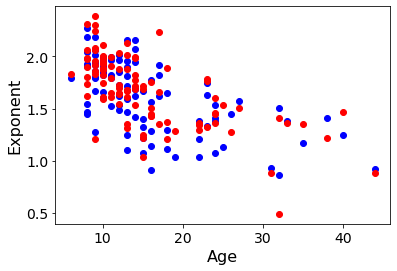

In [15]:
# Plot EC & EO Data Together
_, ax = plt.subplots()
plot_scatter(ap_df.age, ap_df.mean_exp_EO,
             color='blue', add_line=False, ax=ax)
plot_scatter(ap_df.age, ap_df.mean_exp_EC,
             xlabel='Age', ylabel='Exponent', 
             color='red', add_line=False, ax=ax)

In [16]:
# Check the correlation between exponent & age, for EO & EC
print(corr_func(ap_df.age, ap_df.median_exp_EO))
print(corr_func(ap_df.age, ap_df.median_exp_EC))

(-0.6189187272088139, 1.4121745749297113e-11)
(-0.6560088065225629, 3.0252285936166847e-13)


In [17]:
# Check correlation separately in 'kids' & 'adults'

# Kids
inds = ap_df.age < 18
print('Kids Age & Exp correlation (n = {})'.format(sum(inds)))
print('\t', corr_func(ap_df.age[inds], ap_df.mean_exp_EC[inds]))

# Adults
inds = ap_df.age > 18
print('Adults Age & Exp correlation (n = {})'.format(sum(inds)))
print('\t', corr_func(ap_df.age[inds], ap_df.mean_exp_EC[inds]))

Kids Age & Exp correlation (n = 72)
	 (-0.479015914564462, 2.0751093375713305e-05)
Adults Age & Exp correlation (n = 22)
	 (-0.4323370413097024, 0.04448532853360572)


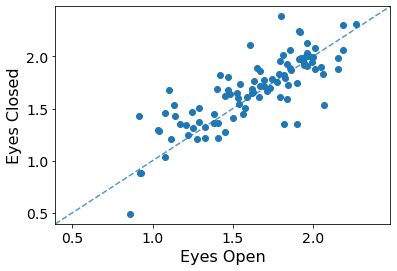

In [18]:
# Plot EC & EO Data Together
plot_scatter(ap_df.mean_exp_EO, ap_df.mean_exp_EC,
             xlabel='Eyes Open', ylabel='Eyes Closed', 
             add_line=False, add_equal=True)

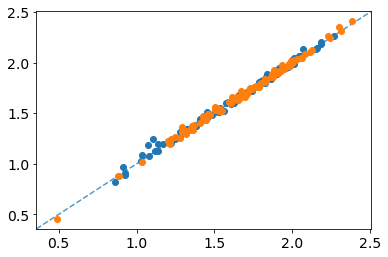

In [19]:
# Compare mean vs median
_, ax = plt.subplots()
plot_scatter(ap_df.mean_exp_EO, ap_df.median_exp_EO,
             add_line=False, ax=ax)
plot_scatter(ap_df.mean_exp_EC, ap_df.median_exp_EC, 
             add_line=False, add_equal=True, ax=ax)

In [20]:
# Correlation between EC and EO data
print(corr_func(ap_df.median_exp_EO, ap_df.median_exp_EC))

(0.8131619143444504, 4.675609593334514e-24)


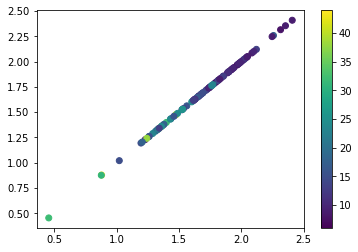

In [21]:
# Scatter with colormap mapping to z value
plt.scatter(ap_df.median_exp_EC, ap_df.median_exp_EC, c=ap_df.age)
plt.colorbar()

### Group Topo Plots

In [22]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../data/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
n_chs = len(ch_labels)

# Read channel montage
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')

# Create the info structure needed by MNE
info = mne.create_info(ch_labels, 500, 'eeg')

# Create the MNE Raw data object
raw = mne.io.RawArray(np.zeros([111, 1]), info, verbose=False)
raw = raw.set_montage(montage)

In [63]:
# Create average exponent values, averaged across all subjects

# Initialize arrays, and grab average exponent results
exp_eo = np.zeros(shape=[n_chs, n_subjs])
exp_ec = np.zeros(shape=[n_chs, n_subjs])
subj_ids = []
for ind, data in enumerate(all_data):
    subj_ids.append(data['ID'])
    exp_eo[:, ind] = data['sls_eo_avg']
    exp_ec[:, ind] = data['sls_ec_avg']
    
# Get list of ages, matching order of data
ages = []
for subj_id in subj_ids:
    ages.append(rmd_df.loc[subj_id].Age)

In [266]:
# Average across subjects
exp_eo_avg = exp_eo.mean(axis=1)
exp_ec_avg = exp_ec.mean(axis=1)

In [270]:
# Settings for exponent plots
vmin, vmax = 1.5, 1.8

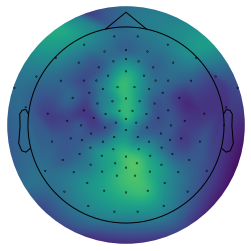

In [271]:
# Plot exponent topography from average eyes-open data
fig, ax = plt.subplots()
mne.viz.plot_topomap(exp_eo_avg, raw.info, contours=0,
                     cmap=cm.viridis, vmin=vmin, vmax=vmax, axes=ax);
if SAVE_FIG:
    fig.savefig('EO-exponent.pdf')

In [272]:
# Check range of data values
print('Min: ', exp_eo_avg.min())
print('Max: ', exp_eo_avg.max())

Min:  1.5435598624258569
Max:  1.7180617223552983


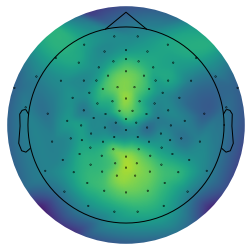

In [273]:
# Plot exponent topography from average eyes-closed data
fig, ax = plt.subplots()
mne.viz.plot_topomap(exp_ec_avg, raw.info, contours=0,
                     cmap=cm.viridis, vmin=vmin, vmax=vmax, axes=ax);
if SAVE_FIG:
    fig.savefig('EC-Exponent.pdf')

In [274]:
# Check range of data values
print('Min: ', exp_ec_avg.min())
print('Max: ', exp_ec_avg.max())

Min:  1.5899515809435727
Max:  1.762382999370315


In [276]:
# Test the difference between EO & EC exponent
ttest_rel(exp_ec_avg, exp_eo_avg)

Ttest_relResult(statistic=24.768156735789958, pvalue=8.397008332747299e-47)

In [350]:
cohens_d(exp_ec_avg, exp_eo_avg)

1.202758303794531

In [354]:
print(np.mean(exp_ec_avg), np.std(exp_ec_avg))
print(np.mean(exp_eo_avg), np.std(exp_eo_avg) )

1.670201186175351 0.03880650438913445
1.6206177609813621 0.04350881833183572


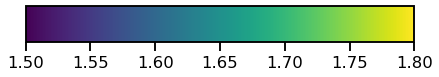

In [348]:
plot_make_colorbar(cm.viridis, vmin, vmax,
                   save_fig=SAVE_FIG, f_name='exp')

In [347]:
# # Create a colorbar for the topography plots
# fig = plt.figure(figsize=(2, 3))
# ax1 = fig.add_axes([0.9, 0.25, 0.15, 0.9])

# cmap = cm.viridis
# norm = colors.Normalize(vmin=1.5, vmax=1.8)

# cb1 = colorbar.ColorbarBase(plt.gca(), cmap=cmap,
#                             norm=norm,
#                             orientation='vertical')

# if SAVE_FIG:
#     plt.savefig('colorbar.pdf', bbox_inches='tight')

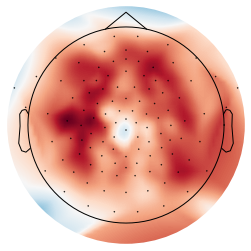

In [31]:
# Create an exponent difference topography - between EC & EO
diff_exp = [exp_ec - exp_eo for exp_ec, exp_eo in zip(exp_ec_avg, exp_eo_avg)]
mne.viz.plot_topomap(diff_exp, raw.info, contours=0);

In [32]:
# Check the range of differences between EC & EO
temp = 'EC/EO range of differences: {:0.4f} to {:0.4f}.'
print(temp.format(min(diff_exp), max(diff_exp)))

EC/EO range of differences: -0.0165 to 0.0966.


In [33]:
# Check the correlation between EC and EO data
corr_func(exp_ec_avg, exp_eo_avg)

(0.8760011453773773, 2.6364221844099972e-36)

#### Topography of Age Correlation

In [171]:
age_ch_corrs_ec = []
age_ch_corrs_eo = []
for ch_data in exp_ec:
    r_val, _ = spearmanr(ch_data, ages)
    age_ch_corrs_ec.append(r_val)
for ch_data in exp_eo:
    r_val, _ = spearmanr(ch_data, ages)
    age_ch_corrs_eo.append(r_val)

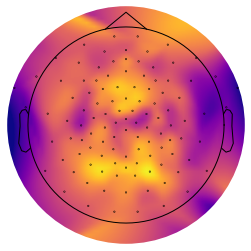

In [340]:
# Set 
#age_ch_corrs = age_ch_corrs_eo
age_ch_corrs = np.mean(np.stack([age_ch_corrs_eo, age_ch_corrs_ec]), 0)

# Plot exponent topography
fig, ax = plt.subplots()
#age_vmin, age_vmax = np.min(age_ch_corrs), np.max(age_ch_corrs)
age_vmin, age_vmax = -0.71, -0.44
mne.viz.plot_topomap(age_ch_corrs, raw.info, contours=0,
                     cmap=cm.plasma_r, vmin=age_vmin, vmax=age_vmax, axes=ax);
if SAVE_FIG:
    fig.savefig('age-corr.pdf')

In [344]:
def plot_make_colorbar(cmap, vmin, vmax, orientation='horizontal',
                       save_fig=False, f_name=''):
    
    fig = plt.figure(figsize=(6, 2))
    ax1 = fig.add_axes([0.15, 0.9, 0.9, 0.25])
    
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cb1 = colorbar.ColorbarBase(plt.gca(), cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

    if SAVE_FIG:
        plt.savefig('colorbar' + ('-' if f_name else '') + f_name + '.pdf',
                    bbox_inches='tight')

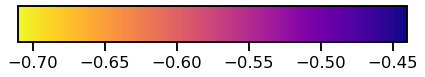

In [345]:
plot_make_colorbar(cm.plasma_r, age_vmin, age_vmax,
                   save_fig=SAVE_FIG, f_name='age')

In [346]:
# # Create a colorbar for the topography plots
# fig = plt.figure(figsize=(10, 2))
# #ax1 = fig.add_axes([0.9, 0.25, 0.15, 0.9])

# cmap = cm.plasma_r
# norm = colors.Normalize(vmin=age_vmin, vmax=age_vmax)

# cb1 = colorbar.ColorbarBase(plt.gca(), cmap=cmap,
#                             norm=norm,
#                             orientation='horizontal')

# if SAVE_FIG:
#     plt.savefig('colorbar-age.pdf', bbox_inches='tight')

### Consistency Measures: Correlations Within & Between Epochs & State

In [34]:
# Calculate correlations within subjects, within and between states
corrs_eo = []
corrs_ec = []
corrs_bet = []

for data in all_data:
    
    corrs_eo.append(np.mean(comb_corrs(data['sls_eo'])))
    corrs_ec.append(np.mean(comb_corrs(data['sls_ec'])))
    corrs_bet.append(np.mean(bet_corrs(data['sls_eo'], data['sls_ec'])))

corrs_ec = [it for it in corrs_ec if not np.isnan(it)]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
# Calculate correlations between subjects, within and between states
corrs_diff_eo = []
corrs_diff_ec = []
corrs_diff_ec_eo = []

for ii, jj in zip(range(n_subjs-1), range(1, n_subjs)):
    
    corrs_diff_eo.append(np.mean(bet_corrs(all_data[ii]['sls_ec'],
                                           all_data[jj]['sls_ec'])))
    
    corrs_diff_ec.append(np.mean(bet_corrs(all_data[ii]['sls_eo'],
                                           all_data[jj]['sls_eo'])))
    
    corrs_diff_ec_eo.append(np.mean(bet_corrs(all_data[ii]['sls_ec'],
                                              all_data[jj]['sls_eo'])))

In [36]:
# Collect all correlations, and labels, together
all_corrs = [corrs_ec, corrs_eo, corrs_bet,
             corrs_diff_ec, corrs_diff_eo, corrs_diff_ec_eo]    
corr_labels = ['EC-Within', 'EO-Within', 'EC/EO-Within',
               'EC-Between', 'EO-Between', 'EO/EC-Between']

In [37]:
# Check average correlation values within & between states & subjects
for corr, label in zip(all_corrs, corr_labels):
    print(label, '\t{:0.4f}'.format(np.mean(corr)))

EC-Within 	0.5259
EO-Within 	0.4002
EC/EO-Within 	0.3808
EC-Between 	0.0473
EO-Between 	0.0552
EO/EC-Between 	0.0492


In [39]:
dd = [np.array(corr) for corr in all_corrs]
dd = np.array(dd)
dd.shape

(6,)

In [40]:
for arr in dd:
    print(arr.shape)

(96,)
(97,)
(97,)
(96,)
(96,)
(96,)


In [241]:
def plot_exp_block_corrs(data, save_fig=False):

    _, ax = plt.subplots(figsize=[7, 5])
    sns.violinplot(data=data, cut=0, linewidth=3,
                   scale='area', 
                   saturation=0.5,
                   color='#ff052b', ax=ax)

    # X-ticks & label for noise levels or # of peaks
    ax.set_xticks(np.arange(0, len(data)))
    
    x_labels = ['EC \n Within',
                'EO \n Within',
                'EC / EO \n Within', 
                'EC / EO \nBetween', 'E', 'F']
    ax.set_xticklabels(x_labels)
    ax.set_ylabel('Correlation')
    
    if save_fig:
        plt.savefig('exp-block-corrs.pdf', bbox_inches='tight')

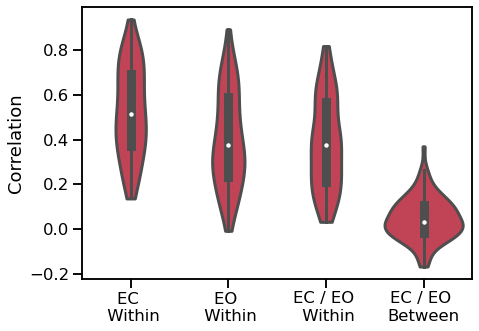

In [242]:
plot_exp_block_corrs(all_corrs[0:4], save_fig=SAVE_FIG)

In [221]:
from scipy.stats import ttest_ind, ttest_1samp
print(ttest_ind(all_corrs[0], all_corrs[1]))
print(ttest_ind(all_corrs[1], all_corrs[2]))
print(ttest_ind(all_corrs[0], all_corrs[2]))
print(ttest_ind(all_corrs[2], all_corrs[3]))

Ttest_indResult(statistic=4.222142163559578, pvalue=3.740433667047963e-05)
Ttest_indResult(statistic=0.6516352650001305, pvalue=0.515415729307898)
Ttest_indResult(statistic=4.989462899500879, pvalue=1.3572636272289702e-06)
Ttest_indResult(statistic=14.6246927954062, pvalue=5.448787337387519e-33)


In [228]:
print(np.mean(all_corrs[3]))
ttest_1samp(all_corrs[3], 0)

0.0472716198892133


Ttest_1sampResult(statistic=4.87961785131513, pvalue=4.27432987515818e-06)

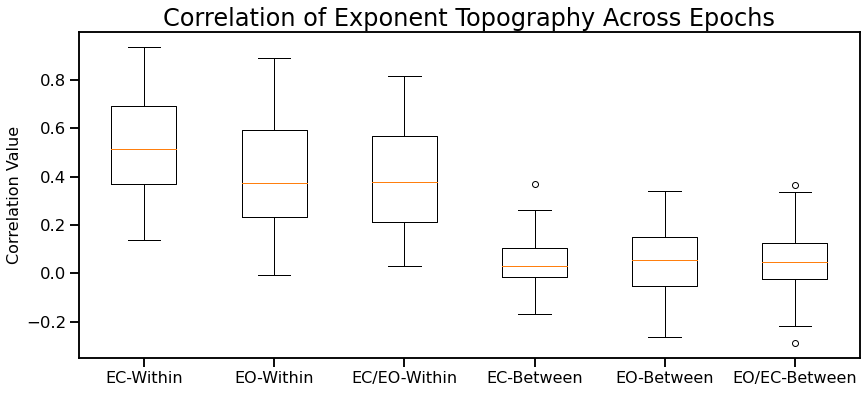

In [53]:
# Plot the correlations across epochs
fig, ax = plt.subplots(figsize=(14, 6))
plt.boxplot(all_corrs);

plt.title('Correlation of Exponent Topography Across Epochs', fontsize=24);
plt.ylabel('Correlation Value', fontsize=16);

xtickNames = plt.setp(ax, xticklabels=corr_labels)
plt.setp(xtickNames, fontsize=16);

# Save out figure
if SAVE_FIG:
    plt.savefig('topo_corr_boxplot.pdf', bbox_inches='tight')

### Spatial Correlations

In [46]:
pos = np.asarray([ch['loc'][:3] for ch in raw.info['chs']])

In [47]:
#from mne.channels.layout import _pol_to_cart, _cart_to_sph
#pos = _pol_to_cart(_cart_to_sph(pos)[:, 1:][:, ::-1])

In [48]:
# Check the spatial correlation
ind = 2
print(corr_func(exp_ec_avg, pos[:, ind]))
print(corr_func(exp_eo_avg, pos[:, ind]))

(0.38138778020716047, 3.6291382367020555e-05)
(0.3115558183827812, 0.0008730349371139935)


In [49]:
# Check the spatial correlation
ind = 1
print(corr_func(exp_ec_avg, pos[:, ind]))
print(corr_func(exp_eo_avg, pos[:, ind]))

(-0.19288671767605078, 0.042532479411693705)
(-0.30664101218485595, 0.0010629105815577633)


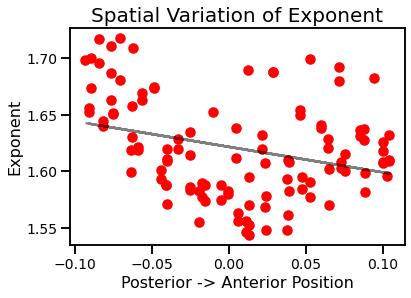

In [50]:
# Plot relation between exponents and position
plot_scatter(pos[:, ind], exp_eo_avg, color='red', 
             title='Spatial Variation of Exponent',
             xlabel='Posterior -> Anterior Position', ylabel='Exponent',
             save_fig=SAVE_FIG, file_name='ant_pos_corr')

In [51]:
# Check the spatial correlation
ind = 0
print(corr_func(exp_ec_avg, abs(pos[:, ind])))
print(corr_func(exp_eo_avg, abs(pos[:, ind])))

(-0.6568743117092382, 4.934210988237092e-15)
(-0.759533370718709, 4.370296783970339e-22)


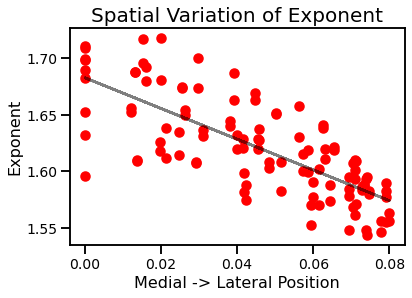

In [52]:
# Plot relation between exponents and position
ind = 0
plot_scatter(abs(pos[:, ind]), exp_eo_avg, color='red',
             title='Spatial Variation of Exponent',
             xlabel='Medial -> Lateral Position', ylabel='Exponent',
             save_fig=SAVE_FIG, file_name='ant_pos_corr')